In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [2]:
!pip install pydrive                             # Package to use Google Drive API - not installed in Colab VM by default
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth                    # Other necessary packages
from oauth2client.client import GoogleCredentials
auth.authenticate_user()                         # Follow prompt in the authorization process
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)
your_module = drive.CreateFile({"id": "176fVmFMju81nPM2jsNOADdU5YnEA6Cl7"})   # "your_module_file_id" is the part after "id=" in the shareable link
your_module.GetContentFile("dlc_practical_prologue.py")          # Save the .py module file to Colab VM
import dlc_practical_prologue as prologue

In [3]:
N = 1000
train_input, train_target, train_classes, test_input, test_target, test_classes = prologue.generate_pair_sets(N)

Extracting ./data/mnist/MNIST/raw/train-images-idx3-ubyte.gz to ./data/mnist/MNIST/raw


Extracting ./data/mnist/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/mnist/MNIST/raw



Extracting ./data/mnist/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/mnist/MNIST/raw


Extracting ./data/mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/mnist/MNIST/raw
Processing...
Done!


/pytorch/torch/csrc/utils/tensor_numpy.cpp:141: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Assuming that we are on a CUDA machine, this should print a CUDA device:

print(device)

cuda:0


In [0]:
train_input_first_approach =  torch.zeros(size = (1000,392))
test_input_first_approach = torch.zeros(size = (1000,392))

for i in range(train_input.size(0)):
    #print(torch.cat((train_input[i,0],train_input[i,1]),0).size())
    train_input_first_approach[i]  = torch.cat((torch.flatten(train_input[i,0]),torch.flatten(train_input[i,1])),0)
    test_input_first_approach[i] = torch.cat((torch.flatten(test_input[i,0]),torch.flatten(test_input[i,1])),0)
    


In [19]:
import torch
import torch.nn.functional as F
from torch import nn,optim

# define the network class
class MyNetwork(nn.Module):
    def __init__(self):
        # call constructor from superclass
        super().__init__()
        
        # define network layers
        self.fc1 = nn.Linear(392, 100)
        self.fc2 = nn.Linear(100, 20)
        self.fc3 = nn.Linear(20, 1)
        self.fc4 = nn.Linear(100, 20)
        
    def forward(self, x):
        # define forward pass
        x = F.relu(self.fc1(x))
        y = F.relu(self.fc4(x))
        x = F.relu(self.fc2(x))
        y = y.view(-1,2,10)
        x = torch.sigmoid(self.fc3(x))
        
        return x,y

# instantiate the model
model = MyNetwork()

# print model architecture
print(model)

MyNetwork(
  (fc1): Linear(in_features=392, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=20, bias=True)
  (fc3): Linear(in_features=20, out_features=1, bias=True)
  (fc4): Linear(in_features=100, out_features=20, bias=True)
)


In [20]:
import torch
import torch.nn.functional as F
from torch import nn,optim

# define the network class
class MyNetworkv2(nn.Module):
    def __init__(self):
        # call constructor from superclass
        super().__init__()
        
        # define network layers
        self.fc1 = nn.Linear(392, 100)
        self.fc2 = nn.Linear(100, 20)
        self.fc3 = nn.Linear(20, 1)
       
        
    def forward(self, x):
        # define forward pass
        x = F.relu(self.fc1(x))
        y = F.relu(self.fc2(x))
        x = F.relu(self.fc2(x))
        y = y.view(-1,2,10)
        x = torch.sigmoid(self.fc3(x))
        
        return x,y

# instantiate the model
model = MyNetwork()

# print model architecture
print(model)

MyNetwork(
  (fc1): Linear(in_features=392, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=20, bias=True)
  (fc3): Linear(in_features=20, out_features=1, bias=True)
  (fc4): Linear(in_features=100, out_features=20, bias=True)
)


In [0]:
def training_model(train_input, train_target, model, batch, lr):
    optimizer = torch.optim.SGD(model.parameters(), lr = lr)
    criterion = nn.BCELoss()
    total_loss = 0
    
    for b in range(0, train_input.size(0), batch):
        output, aux = model(train_input.narrow(0, b, batch))            
        loss = criterion(output, train_target.narrow(0, b, batch))
        model.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss

In [0]:
def compute_nb_errors(model, data_input, data_target, batch):
    
    nb_data_errors = 0

    for b in range(0, data_input.size(0), batch):
        output, _ = model(data_input.narrow(0, b, batch))
        
        predicted_classes = (output>0.5).float()
        
        for k in range(batch):
            if data_target[b + k].item() != predicted_classes[k,0].item():
                nb_data_errors = nb_data_errors + 1
    return nb_data_errors

In [34]:
epochs = 170
losses = torch.zeros((3, epochs))
model = MyNetwork()
for e in range(epochs):
    print("loss", training_model(train_input_first_approach, train_target.float(), model , 100, 0.001))
    print(compute_nb_errors(model, train_input_first_approach,train_target, 100), " ",compute_nb_errors(model, test_input_first_approach,test_target, 100))
    

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:516: UserWarning: Using a target size (torch.Size([100])) that is different to the input size (torch.Size([100, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


loss 17.38149404525757
372   370
loss 8.338894009590149
315   349
loss 6.794998109340668
280   337
loss 5.994999825954437
252   311
loss 5.474985599517822
230   307
loss 5.0964348912239075
216   297
loss 4.795531392097473
207   287
loss 4.546890914440155
195   277
loss 4.3353864550590515
182   271
loss 4.15529391169548
169   263
loss 3.993522673845291
159   263
loss 3.84982568025589
154   256
loss 3.721333533525467
150   249
loss 3.601393163204193
146   248
loss 3.4928242564201355
141   248
loss 3.394347131252289
136   246
loss 3.2985620349645615
131   242
loss 3.2099938094615936
124   243
loss 3.1300226747989655
120   242
loss 3.0496885776519775
115   241
loss 2.9735918790102005
109   239
loss 2.901568353176117
106   241
loss 2.8326897472143173
101   245
loss 2.7639594078063965
100   244
loss 2.700161710381508
99   245
loss 2.634230673313141
98   245
loss 2.572132632136345
95   241
loss 2.514733150601387
93   240
loss 2.4563920199871063
89   242
loss 2.3985538631677628
88   240
loss 2

In [0]:
def training_aux(train_input, train_target, train_classes, model, batch, lr):
    optimizer = torch.optim.SGD(model.parameters(), lr = lr)
    Binary_Criterion = nn.BCELoss()
    Aux_Criterion = nn.CrossEntropyLoss()
    total_loss_aux = 0
    total_loss_bin = 0
    final_total_loss = 0
    for b in range(0, train_input.size(0), batch):
        output, aux = model(train_input.narrow(0, b, batch))
        target_classes = train_classes.narrow(0, b, batch)
        target_comparison = train_target.narrow(0, b, batch)
        aux_loss = Aux_Criterion(aux[:,0], target_classes[:,0]) + Aux_Criterion(aux[:,0], target_classes[:,1])
        binary_loss = Binary_Criterion(output, target_comparison)
        final_loss = 0.9*binary_loss + 0.1*aux_loss
        model.zero_grad()
        final_loss.backward()
        optimizer.step()
        total_loss_aux += aux_loss
        total_loss_bin += binary_loss
        final_total_loss += final_loss
    return final_total_loss, total_loss_aux, total_loss_bin

In [0]:
def compute_nb_errors_aux(model, data_input, data_target, batch):
    
    nb_data_errors = 0

    for b in range(0, data_input.size(0), batch):
        output, _ = model(data_input.narrow(0, b, batch))
        predicted_classes = (output>0.5).float()
        for k in range(batch):
            if data_target[b + k] != predicted_classes[k]:
                nb_data_errors = nb_data_errors + 1
    return nb_data_errors

In [39]:
epochs = 160
losses = torch.zeros((3, epochs))
model2 = MyNetwork()
for e in range(epochs):
    print("loss",training_aux(train_input_first_approach, train_target.float(), train_classes, model2 , 100, 0.001)[2].item())
    print(compute_nb_errors_aux(model2, train_input_first_approach,train_target, 100), " ",compute_nb_errors_aux(model2, test_input_first_approach,test_target, 100))

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:516: UserWarning: Using a target size (torch.Size([100])) that is different to the input size (torch.Size([100, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


loss 11.661955833435059
352   340
loss 7.868963718414307
313   312
loss 6.723896026611328
281   299
loss 6.042056560516357
254   282
loss 5.575667858123779
236   270
loss 5.224243640899658
222   262
loss 4.933218479156494
214   254
loss 4.694690227508545
202   253
loss 4.473226547241211
188   251
loss 4.283199787139893
182   250
loss 4.105892181396484
175   249
loss 3.9460854530334473
167   247
loss 3.805483341217041
159   247
loss 3.671858310699463
156   244
loss 3.550088882446289
148   244
loss 3.4364330768585205
141   241
loss 3.330643653869629
131   239
loss 3.2301552295684814
130   240
loss 3.1352052688598633
121   241
loss 3.04469895362854
117   238
loss 2.958056926727295
114   239
loss 2.871985912322998
110   238
loss 2.7970240116119385
109   237
loss 2.719353199005127
103   233
loss 2.6446471214294434
100   232
loss 2.574352264404297
96   230
loss 2.505014419555664
92   230
loss 2.439955472946167
88   229
loss 2.3786559104919434
81   228
loss 2.3179261684417725
80   226
loss 2.

In [0]:
from torchvision.models.resnet import ResNet, BasicBlock
class MnistResNet(ResNet):
    def __init__(self):
        super(MnistResNet, self).__init__(BasicBlock, [2, 2, 2, 2], num_classes=2)
        self.conv1 = torch.nn.Conv2d(2, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        
    def forward(self, x):
        return torch.softmax(super(MnistResNet, self).forward(x), dim=-1)

In [0]:
import torch.nn.functional as nnf
train_input_first_approach_t = nnf.interpolate(train_input, size=(224, 224), mode='bilinear', align_corners=False)
test_input_first_approach_t = nnf.interpolate(test_input, size=(224, 224), mode='bilinear', align_corners=False)

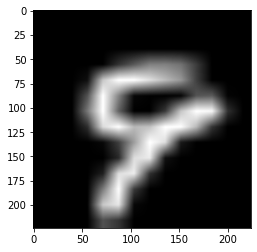

In [7]:
plt.imshow(train_input_first_approach_t[3,0], cmap="gray")
plt.show()

In [0]:
def training_model_resnet(train_input, train_target, model, batch, lr):
    optimizer = torch.optim.SGD(model.parameters(), lr = lr)
    criterion = nn.CrossEntropyLoss()
    total_loss = 0
    
    for b in range(0, train_input.size(0), batch):
        inputs , targets = train_input.narrow(0, b, batch).to(device), train_target.narrow(0, b, batch).to(device)
        output = model(inputs)            
        #print("here", output)
        loss = criterion(output, targets)
        model.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss
def compute_nb_errors_resnet(model, data_input, data_target, batch):
    
    nb_data_errors = 0

    for b in range(0, data_input.size(0), batch):
        inputs  = data_input.narrow(0, b, batch).to(device)
        output = model(inputs)
        #print(output)
        predicted_classes = torch.max(output, 1)
        #print(predicted_classes)
        for k in range(batch):
            if data_target[b + k].item() != predicted_classes[1][k].item():
                nb_data_errors = nb_data_errors + 1
    return nb_data_errors


In [17]:
epochs = 22
losses = torch.zeros((3, epochs))
model3 = MnistResNet()
model3.to(device)
print(train_input_first_approach_t.size())
for e in range(epochs):
    print("loss", training_model_resnet(train_input_first_approach_t, train_target, model3 , 100, 0.05))
    print(compute_nb_errors_resnet(model3, train_input_first_approach_t,train_target, 100), " ",compute_nb_errors_resnet(model3, test_input_first_approach_t,test_target, 100))

torch.Size([1000, 2, 224, 224])
loss 6.959601998329163
449   474
loss 6.892390549182892
403   459
loss 6.822279930114746
398   458
loss 6.7273752093315125
262   406
loss 6.6179521679878235
231   358
loss 6.466337561607361
203   301
loss 6.262643754482269
212   289
loss 5.972923815250397
202   289
loss 5.527912020683289
203   286
loss 5.19652184844017
137   254
loss 4.886555016040802
186   286
loss 4.745081216096878
78   224
loss 4.328017503023148
49   228
loss 4.087607532739639
94   271
loss 3.9768172800540924
27   239
loss 3.851924777030945
17   220
loss 3.456523895263672
8   216
loss 3.3228764832019806
4   210
loss 3.2560932338237762
3   217
loss 3.221977472305298
1   212
loss 3.1909909546375275
0   212
loss 3.1738214790821075
0   212
